# This workbook will describe the process of predict depth at a Combined Sewer Overflow based on catchment rainfall data. An additional feature (time of day) will be used to test if the model is sensitive enough to predict a diurnal profile based on this real usecase in a small catchment 


In [1]:
#import libaries and set up dependencies
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from __future__ import print_function
import tensorflow as tf

# Uncomment the below lines to check that the correct setup has been made for CUDA acceleration of the neural network

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import plotly.graph_objects as go 

from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras import backend as k


plt.style.use('ggplot')


# fix random seed for reproducibility
np.random.seed(10)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11202655822428491106
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22742368256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10509355812049174241
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


## The first step is to import and format teh recorded historical data so that it can be used for modelling

In [2]:
#Load rainfall dataframe
df_rain = pd.read_csv("D:\Linuxstuff\Minworth Rain\df_rain.csv")
df_rain['date_time'] = pd.to_datetime(df_rain['date_time'],dayfirst=True)
#df_rain.to_hdf("/media/nosamaj/Big Disk/Linuxstuff/Minworth Rain/df_rain.hd5",key='df_rain', mode='w')
df_rain.dtypes
df_rain.head(-5)

Unnamed: 0             int64
time                 float64
date_time     datetime64[ns]
RG7                  float64
RG12                 float64
RG15                 float64
RG16                 float64
RG24                 float64
RG28                 float64
RG33                 float64
RG34                 float64
RG35                 float64
RG40                 float64
RG50                 float64
RG52                 float64
RG64                 float64
dtype: object

,Unnamed: 0,time,date_time,RG7,RG12,RG15,RG16,RG24,RG28,RG33,RG34,RG35,RG40,RG50,RG52,RG64
0,1,NaN,2011-12-09 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NaN,2011-12-09 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NaN,2011-12-09 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,NaN,2011-12-09 00:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,NaN,2011-12-09 00:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494594,3557920,NaN,2021-05-05 23:42:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494595,3557921,NaN,2021-05-05 23:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494596,3557922,NaN,2021-05-05 23:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494597,3557923,NaN,2021-05-05 23:48:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Based on GIS assessment and catchment knowledgfe me need profiles 9 10 and 13 from the inforworks model. These correspond to RG35, RG40 and RG64 

In [3]:
df_rain_local = df_rain[['date_time','RG35','RG40','RG64']]
df_rain_local.head()
df_rain_local.dtypes

,date_time,RG35,RG40,RG64
0,2011-12-09 00:00:00,0.0,0.0,0.0
1,2011-12-09 00:02:00,0.0,0.0,0.0
2,2011-12-09 00:04:00,0.0,0.0,0.0
3,2011-12-09 00:06:00,0.0,0.0,0.0
4,2011-12-09 00:08:00,0.0,0.0,0.0


date_time    datetime64[ns]
RG35                float64
RG40                float64
RG64                float64
dtype: object

### Importing and formatting the CSO level data

In [4]:
data_from = pd.to_datetime('2017-01-01 00:00')
data_to = pd.to_datetime('2021-01-01 00:00')

df_logger = pd.read_csv('./dataset/STWW11075.csv')
df_logger['DateTime'] = pd.to_datetime(df_logger['DateTime'],dayfirst=True, infer_datetime_format=True)

In [5]:
import plotly.express as px
#fig = px.line(df_logger, x="DateTime", y= "C1 Depth (mm)", width = 1600)
#fig.show()

### There are some clear recording issues in this data that need to be cleaned up. As an initial pass we are going to just set any readings <0 to 0 as this is the lowest phsically possible value. This will still represent a real world quality dataset without throwing off the training process with outliers

In [6]:
df_logger["C1 Depth (mm)"] = df_logger["C1 Depth (mm)"].clip(lower=0)
#fig = px.line(df_logger, x="DateTime", y= "C1 Depth (mm)", width = 1600)
#fig.show()

### Merging the level data with rainfall data based on the timestamp to create a single table for the recorded period. The level data begins incorrectly formatted. The period for the train test procedure will be 01/01/2017 to 01/01/2021



In [7]:
df_dataset = pd.merge(df_logger, df_rain_local, left_on = "DateTime", right_on = "date_time")
df_dataset = df_dataset.drop("date_time", axis = 1)
df_dataset.head(-5)

,DateTime,C1 Depth (mm),RG35,RG40,RG64
0,2016-10-04 00:52:00,0.0,0.0,0.0,0.0
1,2016-10-04 00:54:00,0.0,0.0,0.0,0.0
2,2016-10-04 01:10:00,46.0,0.0,0.0,0.0
3,2016-10-04 01:12:00,46.0,0.0,0.0,0.0
4,2016-10-04 01:32:00,46.0,0.0,0.0,0.0
...,...,...,...,...,...
1218532,2021-05-05 23:42:00,42.0,0.0,0.0,0.0
1218533,2021-05-05 23:44:00,41.0,0.0,0.0,0.0
1218534,2021-05-05 23:46:00,40.0,0.0,0.0,0.0
1218535,2021-05-05 23:48:00,39.0,0.0,0.0,0.0


In [8]:
data_from = pd.to_datetime('2017-01-01 00:00')
data_to = pd.to_datetime('2021-01-01 00:00')



df_input = df_dataset[df_dataset['DateTime'] >=data_from]
df_testtrain = df_input[df_input['DateTime'] < data_to]
df_testtrain.head()
df_unseen = df_dataset[df_dataset['DateTime'] >= data_to]



,DateTime,C1 Depth (mm),RG35,RG40,RG64
70567,2017-01-01 00:00:00,42.0,0.0,0.0,0.0
70568,2017-01-01 00:02:00,42.0,0.0,0.0,0.0
70569,2017-01-01 00:04:00,42.0,0.0,0.0,0.0
70570,2017-01-01 00:06:00,42.0,0.0,0.0,0.0
70571,2017-01-01 00:08:00,42.0,0.0,0.0,0.0


## Data Transformation

### The data for the date and time parameters needs to be transformed into numerical features for the LSTM to function. Creating columns for the month, weekday, hour and minute separately should suffice

In [9]:
#set the field containing timestamp values as index
df_transform = df_dataset.set_index('DateTime')
#fetch the timestamp componnents and create columns
df_transform['year'] = df_transform.index.year
df_transform['month'] = df_transform.index.month
df_transform['day'] = df_transform.index.weekday
df_transform['week'] = df_transform.index.week
df_transform['hour'] = df_transform.index.hour
df_transform['minute'] = df_transform.index.minute
#see if it worked 
df_transform.head()

C:\Users\jam_m\AppData\Local\Temp/ipykernel_4296/60620551.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_transform['week'] = df_transform.index.week


,C1 Depth (mm),RG35,RG40,RG64,year,month,day,week,hour,minute
DateTime,,,,,,,,,,
2016-10-04 00:52:00,0.0,0.0,0.0,0.0,2016,10,1,40,0,52
2016-10-04 00:54:00,0.0,0.0,0.0,0.0,2016,10,1,40,0,54
2016-10-04 01:10:00,46.0,0.0,0.0,0.0,2016,10,1,40,1,10
2016-10-04 01:12:00,46.0,0.0,0.0,0.0,2016,10,1,40,1,12
2016-10-04 01:32:00,46.0,0.0,0.0,0.0,2016,10,1,40,1,32


In [10]:
# plot dataset for visualiseation
dataset   = df_transform.values
dataset   = df_transform.astype('float32')
#plt.plot(dataset)

The data set comtains a depth in mm and therefore of the order 100, rainfall intesnisty in mm/hr of the order 1 and a decimal time vaule. Therefore it is crucial that the data is standardsised as the significance of the inputs is crucial.

In [11]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
# split into train and test sets this is a 90% train 10% test 
train_size  = int(len(dataset) * 0.75)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#count datapoints to check the split
print(len(train), len(test))

913906 304636


In [13]:
#plot the datasets for visualisation
#print('----------------- TRAINING DATA -----------------')
#plt.plot(train)
#plt.show()
#print('----------------- TEST DATA -----------------')
#plt.plot(test)
#plt.show()


As this is a timeseries sequience problem we need to create a sliding window to determine what period of data we are going to take into account to make predictions. 

In [14]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), [1,2,3,5,6,7,8,9]]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)


In [15]:
# use a n-10 sliding window equivalent to 2 hours of historical data - i.e. we are applying the winddow in this cell
slide_window   = 120
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)    

## We can now reshape tensors for the kersas sequention model input  LSTM model and train it based on the training dataset

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 8, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 8, testX.shape[1]))

In [17]:
#Setup the LSTM
model = tf.keras.Sequential()
model.add(LSTM(8, input_dim=slide_window, return_sequences = True))
model.add(LSTM(8, input_dim=slide_window, return_sequences = True))
model.add(LSTM(8, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=120, verbose=1)

Epoch 1/10
7615/7615 [==============================] - 60s 6ms/step - loss: 3.1265e-04
Epoch 2/10
7615/7615 [==============================] - 43s 6ms/step - loss: 2.6051e-04
Epoch 3/10
7615/7615 [==============================] - 39s 5ms/step - loss: 2.4550e-04
Epoch 4/10
7615/7615 [==============================] - 39s 5ms/step - loss: 2.3295e-04
Epoch 5/10
7615/7615 [==============================] - 39s 5ms/step - loss: 2.1801e-04
Epoch 6/10
7615/7615 [==============================] - 39s 5ms/step - loss: 2.1331e-04
Epoch 7/10
7615/7615 [==============================] - 44s 6ms/step - loss: 2.0626e-04
Epoch 8/10
7615/7615 [==============================] - 45s 6ms/step - loss: 1.9987e-04
Epoch 9/10
7615/7615 [==============================] - 45s 6ms/step - loss: 1.9583e-04
Epoch 10/10
7615/7615 [==============================] - 45s 6ms/step - loss: 1.9523e-04


I haven't had time to play around with hyperparameters. Batch size has been set to 100 in order to make full use of the GPU accelleration

## We can finally see what the predictiosn are doing for us, firstly in the training dataset, and then in the test dataset

In [18]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredict
 
# plot baseline and predictions
#plt.plot(trainY)
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
#plt.show()

#TRy using the plotly library to create the plot

fig = go.Figure()
fig.add_trace(go.Line(data= trainY))


C:\Users\jam_m\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'data'

Did you mean "meta"?

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-time-format#locale_format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant when `stackgroup` is used, and only the
            first `orientation` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the stacking direction. With "v"
            ("h"), the y (x) values of subsequent traces are added.
            Also affects the default value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            textposition .
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-time-format#locale_format for
            details on the date formatting syntax. Every attributes
            that can be specified per-point (the ones that are
            `arrayOk: true`) are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            texttemplate .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format. And for
            dates see: https://github.com/d3/d3-time-
            format#locale_format. We add two items to d3's date
            formatter: "%h" for half of the year as a decimal
            number as well as "%{n}f" for fractional seconds with n
            digits. For example, *2016-10-13 09:15:23.456* with
            tickformat "%H~%M~%S.%2f" would display *09~15~23.46*By
            default the values are formatted using
            `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for  x
            .
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format. And for
            dates see: https://github.com/d3/d3-time-
            format#locale_format. We add two items to d3's date
            formatter: "%h" for half of the year as a decimal
            number as well as "%{n}f" for fractional seconds with n
            digits. For example, *2016-10-13 09:15:23.456* with
            tickformat "%H~%M~%S.%2f" would display *09~15~23.46*By
            default the values are formatted using
            `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for  y
            .
        
Did you mean "meta"?

Bad property path:
data
^^^^

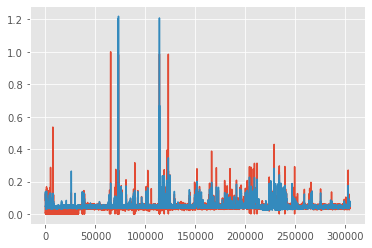

In [ ]:
plt.plot(testY)
plt.plot(testPredictPlot)